## **BERT** 
>__[*original Turtorial Link*](https://www.tensorflow.org/text/tutorials/transformer)__

### Turtorial Summary
1. Downloading the Dataset
2. Text tokenization & detokenization
3. Setup of Input Pipeline 
4. Positional Encoding
5. Buidling Transformer Model from Scracth
6. Setting Hyperparameters 
7. Training and CheckPointing
8. Attention Plot
9. Exporting the saved model



    



In [1]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text


In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

#### Downloading the datasets

In [3]:
## Downloading the Dataset
## useing Tensorflow datasets
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
##if got time look more for what does the take() method refers to 
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))


e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### tokenization & detokenization

In [5]:
### to train a NLP model first we need to tokenized them 
##Converting the text to sequence of token IDS 
## In simple words converting a sentence or words to list of unique tonek-IDS
## for tekenization, in this turtorial we will be using frozen model 


In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

In [7]:
##loading the model
tokenizers=tf.saved_model.load(model_name)

In [8]:
en_examples

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
       b'but what if it were active ?',
       b"but they did n't test for curiosity ."], dtype=object)>

In [9]:
##Example of tokenization 
encoded_en_examples=tokenizers.en.tokenize(en_examples)


In [10]:
## encoded tokens of above en_examples
for row in encoded_en_examples.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


*the shape of each input array is not same as the lenght of the sentence is not fixed*

In [11]:
### Decoding the encoded english examples 
round_trip = tokenizers.en.detokenize(encoded_en_examples)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [12]:
## How does the sequence of words are tokenized 
## using lookup() method


In [13]:
tokens = tokenizers.en.lookup(encoded_en_examples)
print(tokens)

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>


In [14]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.en.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    #print(pt_tokens.row_lengths())
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

In [15]:
lengths

[<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([45, 21, 23, ..., 21, 47, 35], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([27,  9, 12, ...,  9, 23, 28], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 32,  22,  34, ...,  39, 101,  36], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([17, 12, 20, ..., 30, 56, 13], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([48, 37, 27, ..., 92, 21, 49], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([29, 18, 15, ..., 53, 13, 29], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([72, 38, 35, ..., 20, 54, 13], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([38, 18, 16, ..., 11, 26, 11], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 15,  24,  51, ...,  27,  40, 117], dtype=int64)>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([10, 16, 24, ..., 20, 24, 71], dtype=int64)>

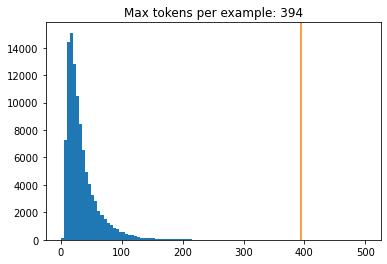

In [16]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

### Setting Input Pipeline

*Defining max_tokens*<br>
>max_tokens: Here max num of words for each batch size 


In [17]:
MAX_TOKENS=128

In [18]:
def tokenize_pairs(pt, en):
    #here pt and en are pt_examples[i] and en_examples[i]
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [19]:
## Downloading the Dataset
## useing Tensorflow datasets
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [20]:
## example
##pt_example, and en_example are from row number "Downloading Dataset 51 number"
pt,en=tokenize_pairs(pt_examples,en_examples)
print('pt\n {} \n\n en\n\n {}'.format(pt,en))

pt
 [[  2  88 120 ...   0   0   0]
 [  2 175 153 ...   0   0   0]
 [  2 101 105 ...   0   0   0]
 ...
 [  2 103 770 ...   0   0   0]
 [  2 133  14 ...   0   0   0]
 [  2  91 301 ...   0   0   0]] 

 en

 [[  2 110  13 ...   0   0   0]
 [  2  45 628 ...   0   0   0]
 [  2  87 140 ...   0   0   0]
 ...
 [  2  77  71 ...   0   0   0]
 [  2 110  13 ...   0   0   0]
 [  2  99 474 ...   0   0   0]]


In [21]:
print('pt.shape: {}\nen.shape: {}'.format(pt.shape,en.shape))


pt.shape: (585, 147)
en.shape: (585, 134)


*bool function to filter out inputs with num_tokens*
<br>tokenize pair are feeded to this function

In [22]:
def filter_max_tokens(pt, en):
    ##Here pt and en are tokenize value of pt_examples and en_examples
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

In [23]:
### Example of above function 
bool_tensor=filter_max_tokens(pt,en)
print(bool_tensor)
## meaning num_tokens is not less than the max tokens 

tf.Tensor(False, shape=(), dtype=bool)


**Example of tf.maximum**
<code>
    x = tf.constant([-5., -1., 0., 0.])
    y = tf.constant([-3.])
    c=tf.math.maximum(x, y)
    print(c)
</code>    
    

Here's a simple input pipeline that processes, shuffles and batches the data:

In [24]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [25]:
def make_batches(ds):
    return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)## Define above
      .filter(filter_max_tokens) #Define above
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [26]:
## Here we can observe that each batch size still have variable length


## Question: During the training process how do they handle different sequence length?
for element in train_batches.take(5):
    print(element[0].shape)

(64, 55)
(64, 79)
(64, 72)
(64, 77)
(64, 83)


### Positional Encoding 

>>look into *An Attention is all we need* paper

In [27]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [28]:

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [29]:
positional_encoding(20,36)

<tf.Tensor: shape=(1, 20, 36), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  5.64216733e-01,
          8.25626731e-01,  3.51695180e-01,  9.36114550e-01,
          2.13780671e-01,  9.76881683e-01,  1.28796190e-01,
          9.91671085e-01,  7.73490295e-02,  9.

### Masking
>Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

*Note: We don't need masking skeleton based Posed based Action Recognition.*

In [30]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

*Similar function in array*
<code>
    def create_padding_mask(seq):
        seq=np.where(seq!=0,0,1)
        return seq
</code>    

*Masking Example*

In [31]:

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### look ahead mask
>The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.<br>This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [32]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [33]:
x = tf.random.uniform((1, 3))

temp = create_look_ahead_mask(x.shape[1]) 
#Value with 1 are masked 
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [34]:
x.shape[1]

3

### Building Transfomrer from scratch
i. Multi-Headed Attention Layer <br>
1. Linear Layer <br>
2. Scaler Dot Product Attention <br>
3. Final Linear Layer<br> 

ii. Encoder <br>
iii. Decoder <br>
iv. Tranformer Model <br>


In [35]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    ## shape is determined by simple matrix multiplication rule 

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    #dk is the square root dimension of keys
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [36]:
## here d_model is feature dimension as well as dimension of the k
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads): ##(self,*,d_model=dimension of k,num_heads)
        
        ##  d_model refer to the dimension of the q,v,k
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model) ## Must Define dense layer separately for all because Dense() always expect same shape but q,v,k may have different shape
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
#     Split the last dimension into (num_heads, depth).
#     Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)

#         #because of this split the computational time is same 
#         #even when the number of heads is increased
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # q.shape= (batch_size, seq_len, d_model) ;Change the last dimesnion to d_model
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model) 
        ## this must assume the d_model and feature length is same 

        return output, attention_weights

*Testing the Above MultiHeadedAttention()*

In [37]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((63,43,64))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([63, 43, 512]), TensorShape([63, 8, 43, 43]))

In [38]:
y.shape

TensorShape([63, 43, 64])

### Point wise feed forward network
>Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [40]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder
Each encoder layer consists of sublayers:
1. Multi-head Attention
2. Point wise feed forward networks

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # att_ouptput.shape=(batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        ##d_model must be equal to feature_dimension otherwise error in addition x + attn_output
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [42]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [43]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        ## To embed to d_model
        ## test code in below cell
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)# Positional encoding for sequence length up to MAX TOKENS

        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:, :seq_len, :] #Slices out the shape not in after embedding

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [44]:
#try the below code to understand more about embedding and positional 
emb=tf.keras.layers.Embedding(8500, 512)
pos=positional_encoding(MAX_TOKENS,512)
print('Pos_emb.shape: ',pos.shape)

x=tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200) #input
seq_len=x.shape[1]
x=emb(x)
print('After Embedding: x.shape ',x.shape)
x+=pos[:,:seq_len,:]
print('After additing positional information: x.shape ',x.shape)

Pos_emb.shape:  (1, 128, 512)
After Embedding: x.shape  (64, 62, 512)
After additing positional information: x.shape  (64, 62, 512)


<code> #Python
emb=tf.keras.layers.Embedding(8500, 512)
pos=positional_encoding(MAX_TOKENS,512)
print('Pos_emb.shape: ',pos.shape)
Pos_emb.shape:  (1, 128, 512)
</code>    

<code> #Python
x=tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200) #input
x=emb(x)
print('After Embedding: x.shape ',x.shape)
</code>

<code> #Python
x *= tf.math.sqrt(tf.cast(512, tf.float32))
print('x.shape: ',x.shape)
</code>

<code> #Python
pos=pos[:,:62,:] # 62 =tf.shape(x)[1] 
print('Pos_emb.shape: ',pos.shape)
</code>

<code>
print(x.shape)=TensorShape([64, 62, 512])
</code>    

In [45]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 69), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)


print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 69, 512)


In [46]:
emb=tf.keras.layers.Embedding(8500, 512)
pos=positional_encoding(MAX_TOKENS,512)
print('Pos_emb.shape: ',pos.shape)

Pos_emb.shape:  (1, 128, 512)


## Decoder layer
Each decoder layer consists of sublayers: <br>
1. Masked multi-head attention (with look ahead mask and padding mask) 
2. *** Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.  ***
3. Point wise feed forward networks.
<br> <br>
Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

>As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output.<b> In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.</b>

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) ## v,k,q order  
        # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  ## v and k are from encoder 
        # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [48]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [49]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
                   rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Creating a Transformer Model


In [50]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
                   target_vocab_size, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               input_vocab_size=input_vocab_size, rate=rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               target_vocab_size=target_vocab_size, rate=rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return padding_mask, look_ahead_mask

### Setting the HyperParameters


In [51]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1
num_heads=8

In [52]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_attention_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

### Test the Transformer

In [53]:
input_vocab_size=tokenizers.pt.get_vocab_size().numpy()
target_vocab_size=tokenizers.en.get_vocab_size().numpy()
print('input_vocab_size: {} and target_vocab_size: {}'.format(input_vocab_size,target_vocab_size))

input_vocab_size: 7765 and target_vocab_size: 7010


In [54]:
input = tf.constant([[1,2,3, 4, 0, 0, 0]])
target = tf.constant([[1,2,3, 0]])

x, attention = transformer((input, target))

In [55]:
input.shape

TensorShape([1, 7])

In [56]:
print(x.shape)
print(attention['decoder_layer1_block1'].shape)
print(attention['decoder_layer4_block2'].shape)

(1, 4, 7010)
(1, 8, 4, 4)
(1, 8, 4, 7)


### Training

In [57]:
## This learning rate is according to the paper "Attention is all we need!"
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

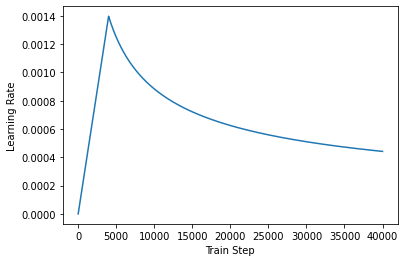

In [58]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [59]:
### Added for testing
print("Added  ")
## Add this to Asus Now
## Added in Asus

Added  


## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.



In [60]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [61]:

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):

  """
  pred will have a shape of Batch_SIZE,NUM_TOKENS(Sequences),TARGET_VOCAB_SIZE
  tf.argmax(pred, axis=2); will have a shape of Batch_SIZE,NUM_TOKENS(Sequences); this shape is same as that of real.shape
  """;
  accuracies = tf.equal(real, tf.argmax(pred, axis=2)) ## return arr of bool(True if real_tokens == pred_tokens)

  mask = tf.math.logical_not(tf.math.equal(real, 0))# Return arr of bool(True if real does not have 0)
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
     

In [62]:
arr1=tf.Variable([1,2,3,4,5,6,0])
arr2=tf.Variable([1,16,18,12,5,6,0])

In [63]:
tf.equal(arr1,arr2)

<tf.Tensor: shape=(7,), dtype=bool, numpy=array([ True, False, False, False,  True,  True,  True])>

In [64]:
tf.math.logical_not(tf.equal(arr1,0))

<tf.Tensor: shape=(7,), dtype=bool, numpy=array([ True,  True,  True,  True,  True,  True, False])>

In [65]:
tf.argmax(tf.random.normal(shape=(16,10)),axis=1)

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([5, 5, 5, 0, 8, 3, 9, 9, 9, 1, 0, 6, 5, 8, 8, 2], dtype=int64)>

In [66]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
     

## Training and checkpointing

In [67]:

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [68]:

checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')
     

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence = 'SOS A lion in the jungle is sleeping EOS'` becomes:

* `tar_inp =  'SOS A lion in the jungle is sleeping'`
* `tar_real = 'A lion in the jungle is sleeping EOS'`

A transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the model predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [69]:
EPOCHS = 20

In [70]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]  # why except the last token in each token? The last token is "END" ; This is done because the training is shifter ri
  tar_real = tar[:, 1:] # Why except the first token

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    
    # We notice that the transformer is feeded with tar_input(containing SOS and excluding EOS). As a result in the predicted word start from first word after sos and end with EOS. 
    # Thus the target loss_function as ground truth value we exclude the SOS, Because the prediction is also right shifted. 
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [72]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  1787008   
                                                                 
 decoder_1 (Decoder)         multiple                  1955584   
                                                                 
 dense_161 (Dense)           multiple                  904290    
                                                                 
Total params: 4,646,882
Trainable params: 4,646,882
Non-trainable params: 0
_________________________________________________________________


Portuguese is used as the input language and English is the target language.

In [76]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.4448 Accuracy 0.6879
Epoch 1 Batch 50 Loss 1.3393 Accuracy 0.7002
Epoch 1 Batch 100 Loss 1.3574 Accuracy 0.6970
Epoch 1 Batch 150 Loss 1.3693 Accuracy 0.6949
Epoch 1 Batch 200 Loss 1.3775 Accuracy 0.6932
Epoch 1 Batch 250 Loss 1.3877 Accuracy 0.6911
Epoch 1 Batch 300 Loss 1.3984 Accuracy 0.6892
Epoch 1 Batch 350 Loss 1.4005 Accuracy 0.6888
Epoch 1 Batch 400 Loss 1.4074 Accuracy 0.6876
Epoch 1 Batch 450 Loss 1.4146 Accuracy 0.6864
Epoch 1 Batch 500 Loss 1.4200 Accuracy 0.6854
Epoch 1 Batch 550 Loss 1.4253 Accuracy 0.6844
Epoch 1 Batch 600 Loss 1.4319 Accuracy 0.6834
Epoch 1 Batch 650 Loss 1.4388 Accuracy 0.6824
Epoch 1 Loss 1.4438 Accuracy 0.6817
Time taken for 1 epoch: 132.35 secs

Epoch 2 Batch 0 Loss 1.4448 Accuracy 0.6776
Epoch 2 Batch 50 Loss 1.3294 Accuracy 0.7004
Epoch 2 Batch 100 Loss 1.3496 Accuracy 0.6972
Epoch 2 Batch 150 Loss 1.3608 Accuracy 0.6948
Epoch 2 Batch 200 Loss 1.3609 Accuracy 0.6951
Epoch 2 Batch 250 Loss 1.3632 Accuracy 0.6942
Epoch 2 Batch

# Inference

In [77]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is english, initialize the output with the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size) # Why we select output from the last token? 

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [108]:
translator=Translator(tokenizers=tokenizers,transformer=transformer)

In [88]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [89]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence),)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to fix .
Ground truth   : this is a problem we have to solve .


In [109]:
translator(tf.constant(sentence),max_length=25)

(<tf.Tensor: shape=(), dtype=string, numpy=b'i read about triumpels in the encyclopedia .'>,
 <tf.Tensor: shape=(19,), dtype=string, numpy=
 array([b'[START]', b'i', b'read', b'about', b't', b'##ri', b'##ump',
        b'##el', b'##s', b'in', b'the', b'e', b'##ncy', b'##c', b'##lo',
        b'##ped', b'##ia', b'.', b'[END]'], dtype=object)>,
 {'decoder_layer1_block1': <tf.Tensor: shape=(1, 8, 18, 18), dtype=float32, numpy=
  array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [9.13957596e-01, 8.60424340e-02, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [9.57431972e-01, 3.91152427e-02, 3.45279998e-03, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           ...,
           [1.01813897e-01, 2.91698333e-02, 1.95127365e-03, ...,
            3.10606629e-01, 0.00000000e+00, 0.00000000e+00],
           [1.44081330e-02, 7.47964904e-03, 1.36619725

## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [111]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence),max_length=25)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i made .
Ground truth   : this is the first book i've ever done.


In [91]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [92]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [93]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [94]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'made', b'.', b'[END]'], dtype=object)>

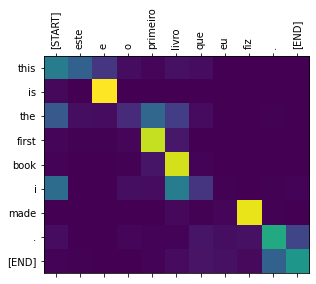

In [95]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [97]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

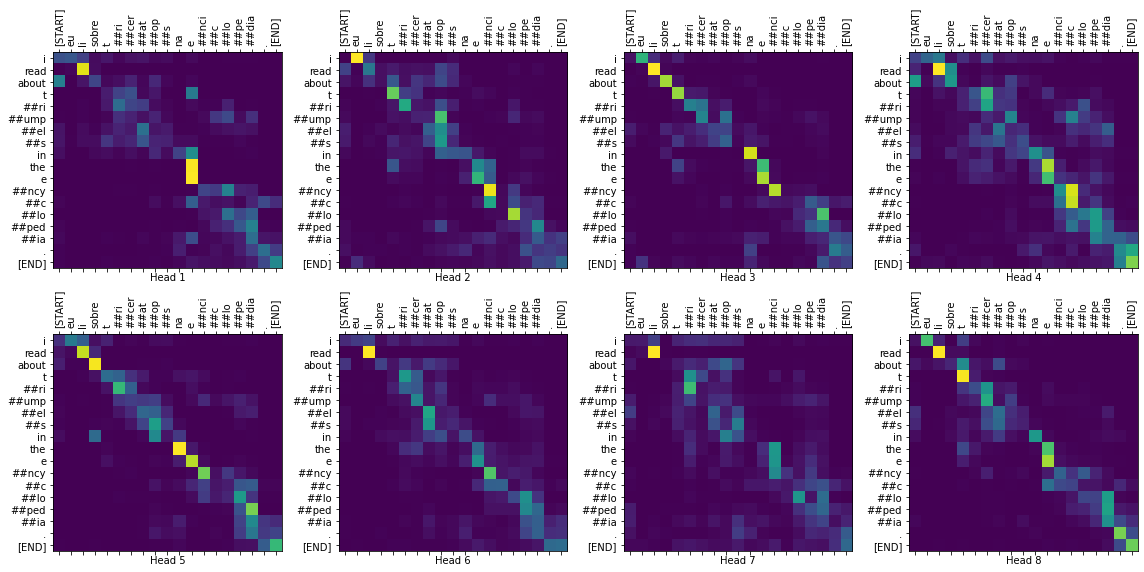

In [98]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triumpels in the encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


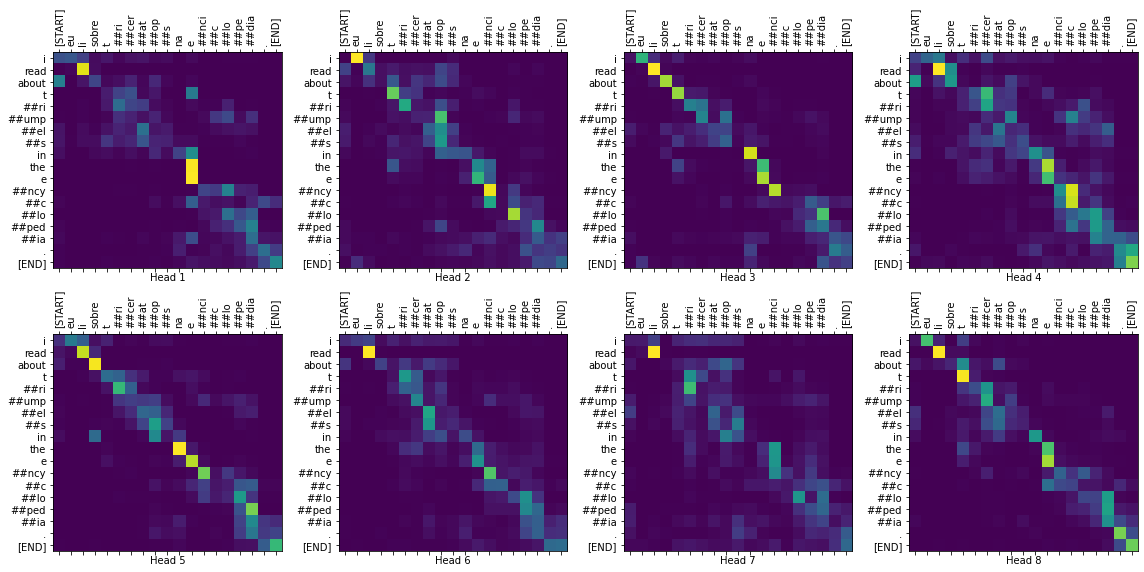

In [99]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [112]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [113]:
translator = ExportTranslator(translator)

In [114]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

In [115]:
tf.saved_model.save(translator, export_dir='translator')

In [116]:
reloaded = tf.saved_model.load('translator')

In [117]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'